In [15]:
#!python -m pip install sentencepiece 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset
import evaluate

# Load the data
data_path = 'data/theming_data_iwgc_25_03_2024.xlsx'  # Update the path if needed
data = pd.read_excel(data_path)
print(data.head())
print(data.columns)

model_name = "RobertaForSequenceClassification"
filename_model = "./models/" + model_name + "/"

       Question                                           freetext  \
0  Improvements  Wash and sanitise properly instead of doing it...   
1  Improvements  Maybe have STR contacts number as only had the...   
2  Improvements  Take on the problem, rather than rushing to di...   
3  Improvements  Take on the problem, rather than rushing to di...   
4  Improvements  Your channels of communication are old fashion...   

                         Theme  
0                  Cleanliness  
1  CommunicationContactDetails  
2         TreatmentIneffective  
3              TreatmentRushed  
4  CommunicationContactDetails  
Index(['Question', 'freetext', 'Theme'], dtype='object')


In [2]:
def prepare_dataset(dataset, new_filename, text_column_name, label_column_name):
    # dictionary of lists
    dict_dataset = {'text': dataset[text_column_name], 'label': dataset[label_column_name]}
    
    df = pd.DataFrame(dict_dataset)
        
    # saving the dataframe
    df.to_csv(new_filename)
    return df

df = prepare_dataset(data, 'theme.csv', 'freetext', 'Theme')

In [3]:
df.head(10)


,text,label
0,Wash and sanitise properly instead of doing it...,Cleanliness
1,Maybe have STR contacts number as only had the...,CommunicationContactDetails
2,"Take on the problem, rather than rushing to di...",TreatmentIneffective
3,"Take on the problem, rather than rushing to di...",TreatmentRushed
4,Your channels of communication are old fashion...,CommunicationContactDetails
5,Upon entering the building I was unsure which ...,FacilitiesNavigation
6,Pharmacy wait times \nWaited nearly an hour fo...,TimeWaitingUnspecified
7,Pharmacy wait times \nWaited nearly an hour fo...,TreatmentMedication
8,"Better signage, when I first visited I could n...",FacilitiesNavigation
9,A receptionist on the desk would have helped!,StaffMore


Text(0.5, 1.0, 'Top 15 Distribution of Classes')

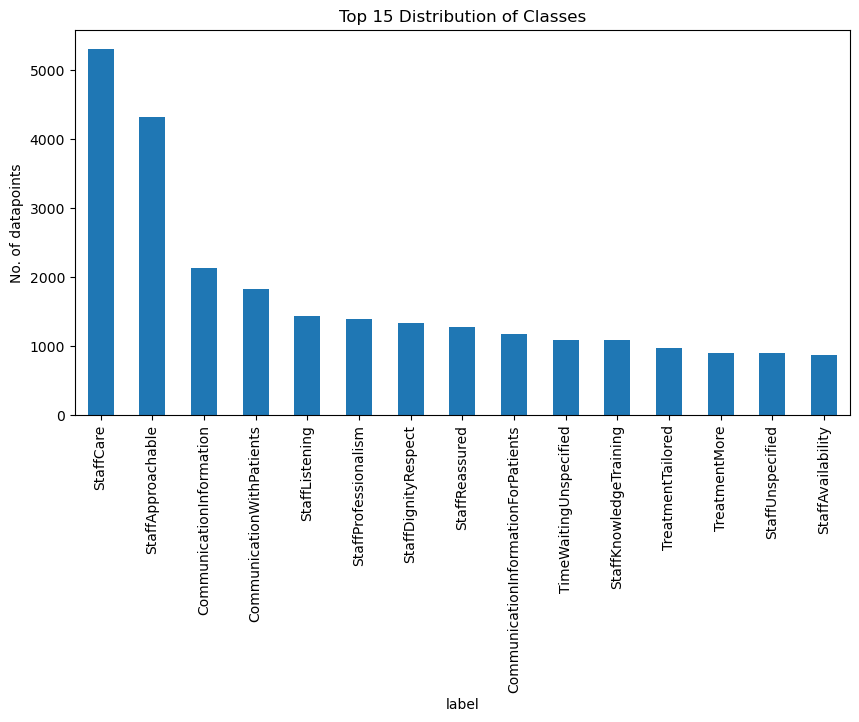

In [4]:
plt.figure(figsize=(10, 5))
num_labels = 15
top_10_classes = df['label'].value_counts().head(num_labels)
top_10_classes.plot(kind='bar')
plt.ylabel('No. of datapoints')
plt.title(f'Top {num_labels} Distribution of Classes')

In [171]:
def keep_top_n_classes(df, num_labels):
    df = df.loc[df['label'].isin(df['label'].value_counts().head(num_labels).index)]
    return df
top_df = keep_top_n_classes(df, num_labels)
top_df


,text,label
6,Pharmacy wait times \nWaited nearly an hour fo...,TimeWaitingUnspecified
13,to improve waiting time,TimeWaitingUnspecified
15,Giving the patient their diagnosis on paper ra...,CommunicationInformationForPatients
18,Surprised that there were only 3 appointments.,TreatmentMore
20,None really as far as District Nurses were con...,CommunicationWithPatients
...,...,...
44151,"Initially, I was apprehensive about speaking t...",CommunicationWithPatients
44152,"Initially, I was apprehensive about speaking t...",StaffListening
44153,The appointment was beneficial and I believe t...,StaffKnowledgeTraining
44154,The appointment was beneficial and I believe t...,StaffDignityRespect


In [172]:
def convert_labels_to_int(df):
    print(df['label'].unique())
    original_labels = {}
    for i, label in enumerate(df['label'].unique()):
        print(i, label)
        original_labels[i] = label
        df['label'].replace({label:i}, inplace=True)
    return df, original_labels

if top_df['label'].dtype == 'object':
    print('ici')
    top_df, original_labels = convert_labels_to_int(top_df)
top_df['label'].head()

ici
['TimeWaitingUnspecified' 'CommunicationInformationForPatients'
 'TreatmentMore' 'CommunicationWithPatients' 'StaffAvailability'
 'StaffKnowledgeTraining' 'StaffProfessionalism' 'StaffListening'
 'StaffDignityRespect' 'TreatmentTailored' 'StaffApproachable' 'StaffCare'
 'CommunicationInformation' 'StaffUnspecified' 'StaffReassured']
0 TimeWaitingUnspecified
1 CommunicationInformationForPatients
2 TreatmentMore
3 CommunicationWithPatients
4 StaffAvailability
5 StaffKnowledgeTraining
6 StaffProfessionalism
7 StaffListening
8 StaffDignityRespect
9 TreatmentTailored
10 StaffApproachable
11 StaffCare
12 CommunicationInformation
13 StaffUnspecified
14 StaffReassured


C:\Users\Julien Delaunay\AppData\Local\Temp\ipykernel_20992\1782750260.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'].replace({label:i}, inplace=True)


6     0
13    0
15    1
18    2
20    3
Name: label, dtype: int64

In [7]:
top_df.dropna(inplace=True)
top_df.head()

C:\Users\Julien Delaunay\AppData\Local\Temp\ipykernel_20992\1800316103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df.dropna(inplace=True)


,text,label
6,Pharmacy wait times \nWaited nearly an hour fo...,0
13,to improve waiting time,0
15,Giving the patient their diagnosis on paper ra...,1
18,Surprised that there were only 3 appointments.,2
20,None really as far as District Nurses were con...,3


In [38]:
multi_labels_df = pd.read_csv('multi-label-theme.csv')
multi_labels_df.drop(['Unnamed: 0'], axis=1, inplace=True)

temp_labels = multi_labels_df['label']
new_labels = []
for list_labels in temp_labels:
    labels = list_labels[1:-1]
    labels = labels.replace('.', '')
    new_list_labels = []
    for label in labels:
        if label != ' ':
            new_list_labels.append(float(label))
    new_labels.append(new_list_labels)
multi_labels_df['label'] = new_labels

In [42]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion-multilabel-latest", max_len= 512)
#tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_df, test_df = train_test_split(multi_labels_df[:5000], test_size=0.33, random_state=42)
train_df =  Dataset.from_pandas(train_df)
test_df =  Dataset.from_pandas(test_df)
train_df = train_df.map(tokenize_function, batched=True)
test_df = test_df.map(tokenize_function, batched=True)
    
try:
    model = AutoModelForSequenceClassification.from_pretrained(filename_model)
    print("downloading", filename_model)
except Exception as e:
    if "Roberta" in filename_model:
        model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion-multilabel-latest", problem_type="multi_label_classification",
                                                         ignore_mismatched_sizes=True, num_labels=num_labels)
        print("downloading Roberta model")
    else:
        model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=num_labels)
        print("downloading BERT model")


Map:   0%|          | 0/3350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

downloading ./models/RobertaForSequenceClassification/


In [44]:
from transformers import DataCollatorWithPadding
from sklearn.metrics import classification_report

def train_model(model, train, test, filename_model):
    def multi_label_sigmoid(logits):
        """
        Applies sigmoid to each entry along the last dimension (-1) and then sets negative values to zero.
        """
        sigmoid_activation = 1 / (1 + np.exp(-logits))
        #positive_ratio = np.count_nonzero(sigmoid_activation > 0.5) / sigmoid_activation.size
        #sigmoid_activation[(sigmoid_activation <= 0) | (sigmoid_activation >= positive_ratio)] = 0
        sigmoid_activation[sigmoid_activation < 0.25] = 0
        sigmoid_activation[sigmoid_activation >= 0.25] = 1
        return sigmoid_activation

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = multi_label_sigmoid(predictions)
        assert predictions.shape[0] == labels.shape[0], "Mismatched lengths between predictions and labels."
        #print('report', classification_report(predictions, labels))
        metrics = []
        test_metrics = {}
        all_metrics = ["accuracy", "f1", "precision", "recall"]
        for metric in all_metrics:
            test_metrics[metric] = []
        
        for i in range(labels.shape[1]):
            temp_metric = clf_metrics.compute(predictions[:, i], labels[:, i])
            for metric in all_metrics:
                test_metrics[metric].append(temp_metric[metric])
            metrics.append(temp_metric)
        
        for metric in all_metrics:
            test_metrics[metric] = sum(test_metrics[metric]) / len(test_metrics[metric])
        print('metrics', test_metrics)
        return test_metrics

    training_args = TrainingArguments(
                output_dir="test_trainer",
                #learning_rate=2e-5,
                learning_rate=2e-3,
                per_device_train_batch_size=3,
                per_device_eval_batch_size=3,
                num_train_epochs=2,
                #weight_decay=0.01,
                weight_decay=0.05,
                evaluation_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
    )

    trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train,
                eval_dataset=test,
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics,
    )
    trainer.train()
    trainer.save_model(filename_model)
    


In [45]:
train_model(model, train_df, test_df, filename_model)

c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/2234 [00:00<?, ?it/s]

{'loss': 0.3751, 'grad_norm': 1.1316250562667847, 'learning_rate': 0.0015523724261414502, 'epoch': 0.45}
{'loss': 0.34, 'grad_norm': 1.5961205959320068, 'learning_rate': 0.0011047448522829007, 'epoch': 0.9}


  0%|          | 0/550 [00:00<?, ?it/s]

c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn

metrics {'accuracy': 0.8794747474747476, 'f1': 0.033469511272507184, 'precision': 0.022343434343434342, 'recall': 0.06666666666666667}
{'eval_loss': 0.35607296228408813, 'eval_accuracy': 0.8794747474747476, 'eval_f1': 0.033469511272507184, 'eval_precision': 0.022343434343434342, 'eval_recall': 0.06666666666666667, 'eval_runtime': 57661.9871, 'eval_samples_per_second': 0.029, 'eval_steps_per_second': 0.01, 'epoch': 1.0}
{'loss': 0.3371, 'grad_norm': 1.2625782489776611, 'learning_rate': 0.000657117278424351, 'epoch': 1.34}
{'loss': 0.3074, 'grad_norm': 1.0326229333877563, 'learning_rate': 0.00020948970456580128, 'epoch': 1.79}


  0%|          | 0/550 [00:00<?, ?it/s]

c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Julien Delaunay\.conda\envs\iwgc\Lib\site-packages\sklearn

metrics {'accuracy': 0.8794747474747476, 'f1': 0.033469511272507184, 'precision': 0.022343434343434342, 'recall': 0.06666666666666667}
{'eval_loss': 0.29576393961906433, 'eval_accuracy': 0.8794747474747476, 'eval_f1': 0.033469511272507184, 'eval_precision': 0.022343434343434342, 'eval_recall': 0.06666666666666667, 'eval_runtime': 2346.9382, 'eval_samples_per_second': 0.703, 'eval_steps_per_second': 0.234, 'epoch': 2.0}
{'train_runtime': 85403.7019, 'train_samples_per_second': 0.078, 'train_steps_per_second': 0.026, 'train_loss': 0.33673748333964265, 'epoch': 2.0}


In [46]:
test_model = RobertaForSequenceClassification.from_pretrained("./models/RobertaForSequenceClassification/", problem_type="multi_label_classification",
                                                         ignore_mismatched_sizes=True, num_labels=num_labels)

In [174]:
def accuracy(predicted_class_ids, true_labels):
    def flat_accuracy(predicted_class_ids, true_labels):
        if isinstance(true_labels, torch.Tensor):
            true_labels = true_labels.bool()
        correct_predictions = torch.eq(predicted_class_ids, true_labels).float()
        total_correct = torch.sum(correct_predictions)
        total_elements = torch.numel(true_labels)
        return total_correct / total_elements

    inner_accuracies = [flat_accuracy(predicted_class_ids[i], true_labels[i]) for i in range(len(predicted_class_ids))]

    return sum(inner_accuracies) / len(inner_accuracies)

In [173]:
input_texts = ["This doctor is very good as he answers all my trouble with confidence. Moreover, I observed that the furniture are well organized. Thanks for all",
                   'STOP']
inputs = tokenizer(input_texts, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

broadcast_shape = (len(input_texts), logits.shape[-1])
broadcast_sigmoid = torch.sigmoid(logits).expand(broadcast_shape)
filtered_sigmoid = broadcast_sigmoid > 0.1

#predicted_class_ids = torch.arange(logits.shape[-1]).unsqueeze(0).repeat(len(input_texts), 1)
#selected_class_ids = predicted_class_ids[filtered_sigmoid]

actual_labels = torch.zeros(len(input_texts), num_labels).long()
labels = [[3, 10, 11], [3, 10]]
for i, label in enumerate(labels):
    actual_labels[i, label] = 1

accuracy_score = accuracy(filtered_sigmoid, actual_labels)
print(f"Accuracy Score: {accuracy_score.item() * 100:.2f}%")


Accuracy Score: 96.67%


In [183]:
def convert_labels_to_text(labels, original_labels):
    predicted_classes = []
    for label_text in labels:
        predicted_class = []
        for index, label in enumerate(label_text):
            if label:
                predicted_class.append(original_labels[index])
        predicted_classes.append(predicted_class)
    return predicted_classes
print(convert_labels_to_text(filtered_sigmoid, original_labels))
convert_labels_to_text(labels, original_labels)

[['CommunicationWithPatients', 'StaffApproachable', 'StaffCare'], ['CommunicationWithPatients', 'StaffApproachable', 'StaffCare']]


[['TimeWaitingUnspecified',
  'CommunicationInformationForPatients',
  'TreatmentMore'],
 ['TimeWaitingUnspecified', 'CommunicationInformationForPatients']]

In [16]:
# Binary Classifier
def train_model(model, train, test, filename_model):
    metric = evaluate.load("accuracy")
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=test,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    trainer.save_model(filename_model)
    

In [12]:
#train_model(model, train_df, test_df, filename_model)